# What is MDAnalysis ?


**MDAnalysis** is a Python open-source toolkit dedicated to the analysis of molecular dynamics trajectories. It is developed and maintained by a global community of scientists and it is free.  
It provides powerful and flexible framework for working with MD data, allowing to analyze trajectory files from various simulation packages.  
It was initially presented in a [paper released in 2011](https://doi.org/10.1002/jcc.21787) and a [second paper was published in 2016](https://doi.org/10.25080/majora-629e541a-00e) to describe many updates in 2016 for a better global description of the toolkit. The current version is the 2.6.1.



# Installation

Our custom conda environment:
We provide you a yaml file that you can use to generate a conda environment containing all the necessary packages to work with MDAnalysis.

Just run this command in your terminal :
conda env create -f mdanalysis_conda_env.yml

pip:
You can otherwise run the following command to install it with core dependencies :
pip install --upgrade MDAnalysis

# Universe

The Main data structures in the User Interface are Universe and AtomGroup. With them we could do selections, units, topology I/O, trajectory I/O… 

Universe is a class in which the data is loaded. It is the primary object and core interface to Molecular Dynamics and used to Read topology information from a file.

To create a Universe object, we need a topology file such as a PDB file that contains all static information like atoms name and mass, charges, bonds and connectivity… A trajectory file is optionally used in the creation of the Universe object but it must have the coordinates in the same order as atoms in the topology file. 
Universe has two key properties: 
	1. atoms: Systems' atoms
	2. trajectory: the loaded trajectory reader

There are several formats of Universe objects that one can load: 
u=Universe(topology,trajectory)
u=Universe(pdbfile)                                                    
u=Universe(topology,[traj1,traj2,...])                        
u=Universe(topology,traj1,traj2,...)    

In [43]:
import MDAnalysis as mda

# Creation of a Universe using a topology and a trajectory file
u = mda.Universe('MDAnalysis_Programmation_python_2/PDB_tubuline.pdb', 'MDAnalysis_Programmation_python_2/trajectoire_tubuline.dcd')

# Creating a universe using only the coordinates from the second file only
u1 = mda.Universe('MDAnalysis_Programmation_python_2/PDB_tubuline.pdb', 'MDAnalysis_Programmation_python_2/trajectoire_tubuline.dcd', all_coordinates = False)
print(u1.trajectory)

# Creating a universe using only the coordinates from both files
u2 = mda.Universe('MDAnalysis_Programmation_python_2/PDB_tubuline.pdb', 'MDAnalysis_Programmation_python_2/trajectoire_tubuline.dcd', all_coordinates = True)
print(u2.trajectory)

<DCDReader MDAnalysis_Programmation_python_2/trajectoire_tubuline.dcd with 1000 frames of 6924 atoms>
<ChainReader containing PDB_tubuline.pdb, trajectoire_tubuline.dcd with 1001 frames of 6924 atoms>


c:\Users\martb\miniconda3\envs\mdanalysis\Lib\site-packages\MDAnalysis\coordinates\base.py:724: UserWarning: Reader has no dt information, set to 1.0 ps
  return self.ts.dt


In [44]:
# A universe can also be created from scratch
# In this examplewe will create a universe of 1000 water molecules
# For this example we will need the numpy
import numpy as np
n_residues = 1000 # Assigning the number of water molecules
n_atoms = n_residues * 3 # Because a Water molecule contains 3 atoms

# Creating a list of indicies for the residues
resindicies = np.repeat(range(n_residues), 3) 
assert len(resindicies) == n_atoms

# Assigning the water molecules to 1 segment
segindicies =[0] * n_residues

# Creating the universe using
sol = mda.Universe.empty(n_atoms, n_residues = n_residues, atom_resindex = resindicies, residue_segindex = segindicies)
sol

<Universe with 3000 atoms>

# Selection

In [45]:
# AtomGroups are constructed by atoms
atom1 = u.atoms[4]
atom2 = u.atoms[5]
ag = mda.AtomGroup([atom1,atom2])
print(ag)

<AtomGroup [<Atom 5: CA of type C of resname MET, resid 1 and segid PROA and altLoc >, <Atom 6: HA of type H of resname MET, resid 1 and segid PROA and altLoc >]>


In [46]:
# AtomGroups are also created by manipulating another AtomGroup
# Creating an AtomGroup of atoms present in ARG residues
ag = u.atoms.select_atoms('resname ARG')
#print(ag)

# Atomgroups can be indexed, and here we are printing the first atom of the Universe
print(u.atoms[0])

# It is also possible to slice them, here we are printing atoms at index 0, 5 and 10
ag2 = u.atoms[0:11:5] 
print(ag2)

# Splicing returns another AtomGroup, we can still check their indicies in the primary AtomGroup.
ag2.indices

# You can use group and set operators on atom groups
group1 = u.atoms[1:5]
group2 = u.atoms[10:3:-1]

# Concatinating AtomGroups will preserve their order and the duplicates 
grouping = group1 + group2
grouping.indices

<Atom 1: N of type N of resname MET, resid 1 and segid PROA and altLoc >
<AtomGroup [<Atom 1: N of type N of resname MET, resid 1 and segid PROA and altLoc >, <Atom 6: HA of type H of resname MET, resid 1 and segid PROA and altLoc >, <Atom 11: HG1 of type H of resname MET, resid 1 and segid PROA and altLoc >]>


array([ 1,  2,  3,  4, 10,  9,  8,  7,  6,  5,  4], dtype=int64)

In [47]:
# However union will create an AtomGroup with unique atoms ordered according to their topology index
union = group1 | group2
union.indices

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

In [48]:
# You can split or group AtomGroups by their level of connectivity such as residue, molecule, or segment
group3 = u.atoms[:100]
group3.split('residue')

[<AtomGroup with 19 atoms>,
 <AtomGroup with 24 atoms>,
 <AtomGroup with 15 atoms>,
 <AtomGroup with 19 atoms>,
 <AtomGroup with 16 atoms>,
 <AtomGroup with 7 atoms>]

In [49]:
# Or their topology attributes such as masses
group3.groupby('masses')

{32.06: <AtomGroup with 1 atom>,
 1.008: <AtomGroup with 54 atoms>,
 12.011: <AtomGroup with 29 atoms>,
 14.007: <AtomGroup with 9 atoms>,
 15.999: <AtomGroup with 7 atoms>}

In [50]:
# Selection of atoms
# You can select atoms using selection keywords
# They are case sensitive, sequentially ordered, and selection are parsed from left to right with parathesis used for grouping
# String selections for names and resdiues are matched with wildcards
# * for any number of any character
# ? for any single character
# [seq] matches the sequence
# [!seq] matches any char not in seq
# [!?] selects empty string

u.select_atoms("protein") # Selects the entire protein

<AtomGroup with 6924 atoms>

In [51]:
u.select_atoms("backbone") # Selects the backbone atoms

<AtomGroup with 1799 atoms>

In [52]:
u.select_atoms("segid PROA") # Selects by segment ID as given in the topology file

<AtomGroup with 6924 atoms>

In [53]:
u.select_atoms("resnum 1:5") # Selects every atom that are in the residies 1 to 5

<AtomGroup with 93 atoms>

In [54]:
u.select_atoms("resname ALA") # Selection by the 3 letter code of the resname

<AtomGroup with 300 atoms>

In [55]:
u.select_atoms("name CA") # Selection by name of atom, here selection of C alpha atoms

<AtomGroup with 450 atoms>

In [56]:
# Selection types can be combined
print(u.select_atoms("segid PROA and resnum 1 and name SD")) # Selection of the SD atom from the PROA segment of the first residue
print(u.select_atoms("segid PROA and resnum 1 and not name H"))# Selection of the all atoms excpet H from the PROA segment of the first residue

<AtomGroup [<Atom 13: SD of type S of resname MET, resid 1 and segid PROA and altLoc >]>
<AtomGroup [<Atom 1: N of type N of resname MET, resid 1 and segid PROA and altLoc >, <Atom 2: HT1 of type H of resname MET, resid 1 and segid PROA and altLoc >, <Atom 3: HT2 of type H of resname MET, resid 1 and segid PROA and altLoc >, ..., <Atom 17: HE3 of type H of resname MET, resid 1 and segid PROA and altLoc >, <Atom 18: C of type C of resname MET, resid 1 and segid PROA and altLoc >, <Atom 19: O of type O of resname MET, resid 1 and segid PROA and altLoc >]>


# Storage and visualization tools

# Data storage
The starting point when working with molecular dynamics is to know the file you
are using and their extension. You can refer to this [official list](https://userguide.mdanalysis.org/stable/formats/index.html) to see the
the format supported by MDAnalysis.
Data can be stored in multiple raw forms such as a data file or transformed
forms like a plot or a movie, some of them will be presented in this section.

## Writing out data

### Frame and trajectories
MDAnalysis allows you to write frames or trajectories in any of the supported format with `.write()`:

In [57]:
import MDAnalysis as mda


reference = mda.Universe('MDAnalysis_Programmation_python_2/PDB_tubuline.pdb', 
                         'MDAnalysis_Programmation_python_2/trajectoire_tubuline.dcd')


ag = reference.select_atoms("name CA")

# Writing the current frame to a file
ag.write("c-alpha.pdb")

# Writing the trajectory using the 'frames' keyword
ag.write('c-alpha_all.pdb', frames='all')

# Example for slice
ag.write('c-alpha_skip2.pdb', frames=reference.trajectory[::2])

c:\Users\martb\miniconda3\envs\mdanalysis\Lib\site-packages\MDAnalysis\coordinates\PDB.py:775: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
c:\Users\martb\miniconda3\envs\mdanalysis\Lib\site-packages\MDAnalysis\coordinates\PDB.py:1151: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"


# Visualisation

## Plotting trajectories
Generally, trajectories are worked on through iteration so that only the
information of the active frame are considered. A way to visualize specific
information from each frame is to extract them in a list and convert them into
other data structures such as a *Numpy* array or a *Pandas* DataFrame. This way,
plotting with *Matplotlib* can be easier to do:

### Radius of gyration using *Pandas*

In [58]:
import pandas as pd
import matplotlib.pyplot as plt


rgyr = []
time = []

protein = reference.select_atoms("protein")

for ts in reference.trajectory:
    # Extract the time from the frame
    time.append(reference.trajectory.time)
    # Extract the protein radius of gyration from the frame
    rgyr.append(protein.radius_of_gyration())

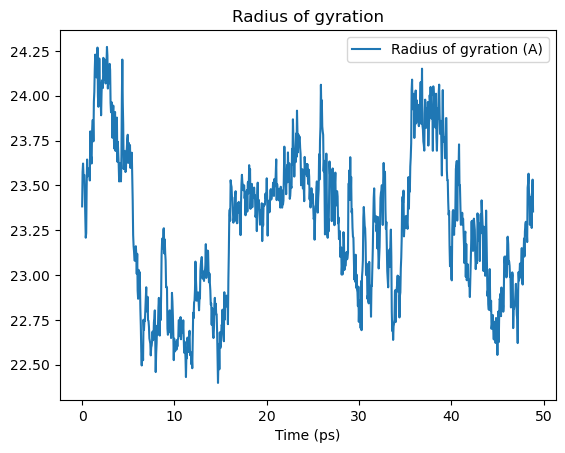

In [68]:
# Create a pandas dataframe
rgyr_df = pd.DataFrame(rgyr, columns=['Radius of gyration (A)'], index=time)
rgyr_df.index.name = 'Time (ps)'

# Create a matplotlib plot
rgyr_df.plot(title='Radius of gyration')                        
plt.show()

## NGLView


[NGL Viewer](http://nglviewer.org/) is an Interactive widget to visualize molecular structures or trajectories in Jupyter notebooks.

You can see [this tutorial](https://projects.volkamerlab.org/teachopencadd/talktorials/T017_advanced_nglview_usage.html#Custom-coloring-schemes-and-representations) from the Volkamerlab for a walkthrough of the NGLView usage.

#### Visualize a structure or a trajectory
You can perform quick visualization for different objects. Here follow a few examples:
- `.show_file()` to visualize your object by automatic recognition of the file from its extension
- `.show_pdbid()` to visualise a PDB structure from its ID
- `.show_mdanalysis` to visualize an `MDAnalysis` Universe or AtomGroup `univ`

In [61]:
import nglview as nv


view = nv.show_mdanalysis(reference)
view

NGLWidget(max_frame=999)

##### Visualizing the first and last structures of the trajectory
It can be interesting to compare frames taken from different conformations adopted during the simulation. Thus we provide an example on how to do this comparison on the first and the last frames of our simulation.  

For a better visualization of the structural differences, a simple alignement will be performed. As the most fluctuating part of the protein where found from the residues 415 to the end, this alignement will be made one the $C\alpha$ of the residues 0 to 415 of the protein.

##### Comparative visualization the most mobile part movements of the tubuline

In [62]:
from MDAnalysis.analysis import align

# Create an independent copy of the mobile Universe
mobile = reference.copy()

# Perform a backbone-wise alignment
aligner = align.AlignTraj(mobile, 
                          reference, 
                          select='backbone and resid 0-400',
                          filename='aligned_to_first_frame.dcd').run()

# Provide aligned coordinates for the trajectory
mobile = mda.Universe('MDAnalysis_Programmation_python_2/PDB_tubuline.pdb', 
                      'aligned_to_first_frame.dcd')

c:\Users\martb\miniconda3\envs\mdanalysis\Lib\site-packages\MDAnalysis\coordinates\DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
c:\Users\martb\miniconda3\envs\mdanalysis\Lib\site-packages\MDAnalysis\coordinates\DCD.py:448: UserWarning: No dimensions set for current frame, zeroed unitcell will be written
  warnings.warn(wmsg)


In [63]:
# Create a view of the mobile trajectory
view = nv.show_mdanalysis(mobile)

# Add the pdb structure in the viewer
view.add_component(reference)

# Update the cartoon representation of the trajectory 
view.update_cartoon(component=0, color='red')
view.update_cartoon(component=1, color='blue')

view

NGLWidget(max_frame=999)

# Align a trajectory on a reference

In order to obtain the correct RMSD or RMSF value of the structure of the tubuline after the simulation, we need to align the protein at the begining of the simulation to itself but on the last frame of the trajectory.

To be able to do that, we will need to use a component of the anaylis module provided by MDAnalysis.




In [64]:
from MDAnalysis.analysis import align

The analysis module contains a lot of different algorithms to extract data from the topologie and the trajectory of our system. 

To perform the alignement, we will need a reference structure and a mobile one which will be aligned onto the reference.

In our case we will select the orignal pdb structure as our reference point and the tubuline in the last frame as our mobile structure.

To do that will use the function *alignto* from the align module. This function takes 8 arguments:

required:
- mobile (Universe | AtomGroup): the structure that will be aligned
- reference (Universe | AtomGroup): the structure on which the alignement is based on

optional:
- select (str | dict | tuple): filter on which groups of atoms are chosen for the alignment. If a single string is used, the selection need to be valid for both the mobile and the reference AtomGroups. We can perform seperate selection filters by using a dictionnary (i.e. {'mobile': 'mySelection1', 'reference': 'mySelection2}) or a tuple.
- match_atoms (bool): align the mobile and reference structure atom by atom.
- weights: ("mass" | None | array): used in case you want to do a weighted RMSD alignement or have a different center of mass. You can either use the mass of the atoms or input an array with custom weights.
- tol_mass (float): Threshold where the alignment will be aborted if two matching atoms differ by more than tol_mass
- strict (bool): Raise an error if an atom is different in the mobile or reference selections.

And in returns, we obtain a tuple containing the RMSD before the alignment and the RMSD after.

In [65]:
reference = mda.Universe('MDAnalysis_Programmation_python_2/PDB_tubuline.pdb')
mobile = mda.Universe('MDAnalysis_Programmation_python_2/PDB_tubuline.pdb', 'MDAnalysis_Programmation_python_2/trajectoire_tubuline.dcd')

# Take the last frame of the simulation
mobile.trajectory[-1]

align.alignto(mobile, reference, select='protein and name CA', weights='mass')


c:\Users\martb\miniconda3\envs\mdanalysis\Lib\site-packages\MDAnalysis\coordinates\DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


(8.385687101272765, 7.929769066240307)

# Determinate flexible loops with RMSF

What means RMSF and what is it use for ?

Before explaining RMSF, let me introduce RMSD. 
- RMSD means Root Mean Square Deviation. It represents the difference between two structures and in the case of simulations, the motion of our whole structure of interest throughout the simulation. It is basically plotted as structure variation vs. time.

- RMSF means Root Mean Square Fluctuation. It also shows fluctuations all over the simulations but for specific atoms or residues. It can highlight which residue or part of our structure are the most flexible. It is also plotted as residue/part of structure vs. time.

Now that we have explained the theory, let's look at a practical example with our tubuline.

In [66]:
# Import specific package for analysis and in this case : rms (rmsd, rmsf) 
from MDAnalysis.analysis import rms

# First you have to select what part of your structure you want to look at
# For now we take as example the alpha carbons of the tubulin
c_alphas = u.select_atoms('protein and name CA')

# Calculate the rmsf for alpha carbons 
R = rms.RMSF(c_alphas).run()

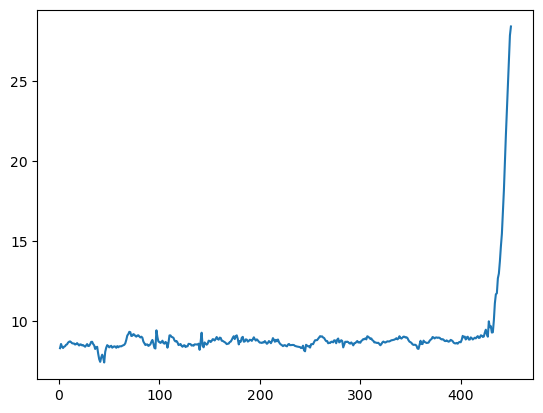

In [67]:
# Import package for plotting
import matplotlib.pyplot as plt

# Then plot your RMSF of alpha carbons
# A graph will be displayed with RMSF values in Angstroms on y-axis and the residue indices on x-axis
plt.plot(c_alphas.resids, R.results.rmsf)

# Other types of analysis featured by MDAnalysis

In addition to the functionalities presented previously, MDAnalysis offers other analysis tools.

## Distances and contacts

You can compute distances between atoms, residues or larger sets. It can give you valuable datas :
- How residues are close during the simulation
- If two residues are in contact if they are within a certain distance
- An overview of the global movement of the system by looking at number of contacts all over the simulation

## Structure

- Having an idea of dihedral angles and secondary structures
- Calculating RDF (Radial Function Distribution) of solvent around certain atoms


## Hydrogen bonds

MDAnalysis has features to analyse hydrogen bonds in a Universe thanks to the function `HydrogenBondAnalysis`